In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os, django
import math
from sklearn.model_selection import KFold


from sklearn.manifold import TSNE
from sklearn.svm import SVC, OneClassSVM
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score

from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from scipy.sparse import hstack

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from django.db.models import Q, F, Sum, Count, FloatField, Case, When, Value, Max
from sklearn.manifold import TSNE
from scoping.models import *
from scoping.views import *


import scoping.utils.learning_utils as lu
import random
import scipy.stats as st


double_figure = (7.2,7.2/8*5)
plt.rc('font',size=7)
plt.rc('axes',titlesize=7)
plt.rc('axes',labelsize=7)
plt.rc('xtick',labelsize=7)
plt.rc('ytick',labelsize=7)
plt.rc('legend',fontsize=7)
plt.rc('figure',titlesize=7)


now=datetime.datetime.now()

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.decomposition.nmf module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


## First we say what query and project we are interested in

In [2]:
pid = 217
qid = 7966
qid = 7965
qids = [7965,7966]
q = Query.objects.get(pk=qid)
p = Project.objects.get(pk=pid)

print(q.doc_set.count())
q.r_count

407957


407957

## Get a full list of ratings

In [3]:
cat_refs = {}
annotations = {}
for c in Category.objects.filter(project=p).order_by('level','name'):
    if "<hidden>" in c.name:
        continue
    cat_refs[c.name] = DocUserCat.objects.filter(
        doc = OuterRef('doc__pk'),
        user = OuterRef('user__pk'),
        category=c
    )
    annotations[c.name] = Exists(cat_refs[c.name])
    
dos = DocOwnership.objects.filter(
    tag__query__in=qids, relevant__gt=0
).annotate(**annotations)

print(dos.count())

cols = ['doc__id','doc__title','doc__content','user__username','tag__title','relevant'] + list(annotations.keys())
df = pd.DataFrame.from_dict(dos.values(*cols))[cols].sort_values('doc__id').reset_index(drop=True)*1
df.to_csv('data/doc_ratings.csv',index=False)

8898


In [5]:
dos = DocOwnership.objects.filter(
    tag__query__in=qids, relevant__gt=0
)
cols = ['id','doc__id','doc__title','doc__content','user__username','tag__title','relevant']
df = pd.DataFrame.from_dict(dos.values(*cols))[cols].sort_values('doc__id').reset_index(drop=True)*1
df.head()

,id,doc__id,doc__title,doc__content,user__username,tag__title,relevant
0,1209686,305,Impact of the Combination of Land Use Activiti...,A study to assess the combined effects of land...,maowenxin2014@163.com,Adaptation recategorisation,1
1,812599,305,Impact of the Combination of Land Use Activiti...,A study to assess the combined effects of land...,maowenxin2014@163.com,Sample 1,1
2,1209687,2107,Climate change and health and social care: Def...,Health and social care systems (including the ...,maowenxin2014@163.com,Adaptation recategorisation,1
3,851873,2107,Climate change and health and social care: Def...,Health and social care systems (including the ...,maowenxin2014@163.com,predicted adaptation sample 2020-02-06 17:11,1
4,813141,2164,Design of the AmeriFlux portable eddy covarian...,The AmeriFlux network continues to improve the...,maowenxin2014@163.com,random sample 2019-12-19 15:04,1


### And we retrieve those documents that have been screened in that query, and get the majority rating

In [6]:
import statistics

def mode_na(x):
    try:
        return statistics.mode([y for y in x if y is not np.NaN])
    except:
        return np.NaN
    
columns = [
    'id',
    'content',
    'title',
    'PY',
    'wosarticle__de',
    'wosarticle__wc'
]

# Majority ratings
dos = DocOwnership.objects.filter(
    query__in=qids, 
    relevant__gt=0,
    doc__content__iregex='\w'
)
dodf = pd.DataFrame.from_dict(dos.order_by('finish').values(
    'id','doc_id','user__username','relevant'
))
dodf.loc[dodf['relevant']==2,'relevant'] = 0
dodf.loc[dodf['relevant']==3,'relevant'] = np.NaN

gdf = dodf.groupby('doc_id').agg(lambda x: mode_na(x)).reset_index()[['doc_id','relevant']].rename(columns={"doc_id":"id"})
gdf['seen'] = 1
gdf.loc[pd.isna(gdf['relevant']),'seen'] = np.NaN

seen_df = gdf
ddf = pd.DataFrame.from_dict(
    Doc.objects.filter(pk__in=seen_df['id']).values(*columns)
)
seen_df = pd.merge(ddf,seen_df)
print(seen_df.shape)
seen_df.head()


(4032, 8)


,PY,content,id,title,wosarticle__de,wosarticle__wc,relevant,seen
0,2018,A model of two regions with a common wood mark...,1945105,Negative leakage: The key role of forest manag...,Forest carbon; Institutions; Management regime...,[Economics; Forestry],1.0,1.0
1,2017,This paper analyzes hybrid emissions trading s...,785897,Combining price and quantity controls under pa...,Emission trading; Hybrid regulation; Partition...,[Economics],1.0,1.0
2,2008,This study explores the economic feasibility o...,571734,Fast-growing poplar plantations as a bioenergy...,short rotation species; afforestation; cost-be...,[Agricultural Engineering; Biotechnology & App...,1.0,1.0
3,2015,Based on qualitative research and a case study...,437137,Triggering Community Conservation Through the ...,community conservation; market-based instrumen...,[Development Studies; Environmental Studies; R...,1.0,1.0
4,2007,Article 2 of the United Nations Framework Conv...,196766,"Dangerous anthropogenic interference, dangerou...",None,[Environmental Sciences; Meteorology & Atmosph...,1.0,1.0


### We have a separate list of documents in the query that have not been screened

In [7]:
unseen_docs = q.doc_set.filter(
    content__iregex='\w',
).exclude(pk__in=seen_df['id']).distinct('id')

unseen_df = pd.DataFrame.from_dict(list(unseen_docs.values(*columns)))
unseen_df = unseen_df[columns]
unseen_df['relevant'] = 0
unseen_df['seen'] = 0

print(unseen_df.shape)
unseen_df.head()

(378191, 8)


,id,content,title,PY,wosarticle__de,wosarticle__wc,relevant,seen
0,1,For improved exploitation of the energy conten...,Proof of concept for a new energy-positive was...,2014.0,advanced primary treatment; carbon footprint; ...,"[Engineering, Environmental; Environmental Sci...",0,0
1,3,Geological sequestration of pure carbon dioxid...,Wettability determination by contact angle mea...,2011.0,Contact angle; Wettability; CO2; Sequestration...,"[Chemistry, Physical]",0,0
2,4,"In America, entertainment celebrities have ent...","From sidekick to sideshow - Celebrity, enterta...",2005.0,politics of distraction; celebrity politics; c...,"[Psychology, Clinical; Social Sciences, Interd...",0,0
3,7,In order to evaluate the effects of pH reducti...,Simulating ocean acidification and CO2 leakage...,2016.0,CO2-driven acidification; Rank species sensiti...,[Environmental Sciences],0,0
4,10,The degradation of 2-aminoethanol (MEA) by the...,Study of OH-initiated degradation of 2-aminoet...,2012.0,None,[Meteorology & Atmospheric Sciences],0,0


### And we merge the two, with a column "seen" recording if a document has been seen or not

In [8]:
django.db.connection.close()
df = (pd.concat([seen_df,unseen_df])
      .sort_values('id')
      .sample(frac=1, random_state=1)
      .reset_index(drop=True)
)
y = df['relevant']

seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index

df.head()

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,PY,content,id,relevant,seen,title,wosarticle__de,wosarticle__wc
0,1992.0,Some new aspects of microbiology in water-in-o...,599544,0.0,0.0,SOLUBILIZATION AND GROWTH OF CANDIDA-PSEUDOTRO...,YEAST; GROWTH; ORGANIC SOLVENT; MICROEMULSION;...,[Biotechnology & Applied Microbiology]
1,2018.0,The present experimental study is investigated...,1305496,0.0,0.0,Novel Garcinia gummi-gutta methyl ester (GGME)...,Garcinia gummi-gutta methyl ester; Immobilized...,[Green & Sustainable Science & Technology; Ene...
2,2000.0,The DAYCENT ecosystem model was used to addres...,1860140,0.0,0.0,Interaction of soil carbon sequestration and N...,soil C; N2O flux; climate forcing; land use ma...,[Environmental Sciences]
3,1997.0,A new air mass-based synoptic procedure is use...,615984,0.0,0.0,An evaluation of climate/mortality relationshi...,acclimatization; air mass; climate and human m...,"[Environmental Sciences; Public, Environmental..."
4,2009.0,Fresh produce is increasingly implicated in fo...,328444,0.0,0.0,Persistence of Escherichia coli on Injured ice...,None,[Biotechnology & Applied Microbiology; Food Sc...


### We also get the assignments of these documents to categories, and add these as further columns in our dataframe

In [9]:
dudf = pd.DataFrame.from_dict(
    DocUserCat.objects.filter(
        doc__pk__in=seen_df['id'],category__project=p
    ).values('user__username','doc__id','category__level','category__name')
)
dudf['v'] = 1
dudf['cname'] =  dudf['category__level'].astype(str) + " - " + dudf['category__name']#
dudf = dudf.drop(columns=['category__level','category__name'])
dudf_wide = dudf.pivot_table(index=['doc__id','user__username'],columns="cname", values="v").fillna(0)
print(dudf_wide.shape)
gudf = dudf_wide.groupby(['doc__id']).agg(lambda x: st.mode(x)[0][0]).reset_index()
dudf_wide_r = dudf_wide.reset_index()
dudf_wide_r.columns = ["doc__id",'user__username'] + list(dudf_wide.columns)
dudf_expanded = dudf_wide_r.melt(id_vars=["doc__id","user__username"]).head()
print(gudf.shape)
gudf.tail()

(3065, 45)
(3003, 46)


cname,doc__id,1 - Adaptation,1 - Mitigation,2 - Governance & policies,3 - <hidden>tax/emission trading,3 - Economic instruments,3 - Goal setting,3 - Government procurement & public services<hidden>,3 - Information policies,3 - Information<hidden>,...,4 - Spatial & land-use planning,4 - Subsidy/compensation/ allowance,4 - Targets & goals,4 - Tax,4 - Voluntary agreements,5 - Company & organizations,5 - Local,5 - National,5 - Sub-national/ regional,5 - Supranational & international
2998,1945105,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2999,1945363,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3000,1945365,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3001,1945927,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3002,1945987,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
print(dudf_wide.shape)
no_ma = dudf_wide[
    (dudf_wide['1 - Adaptation']==0) &
    (dudf_wide['1 - Mitigation']==0)
]

docs = Doc.objects.filter(id__in=no_ma.reset_index()['doc__id'])
for tag in Tag.objects.filter(query=q):
    tds = tag.doc_set.filter(pk__in=no_ma.reset_index()['doc__id'])
    if tds.exists():
        print(tag, tds.count())

(3065, 45)


In [11]:
df = pd.merge(df, gudf.rename(columns={"doc__id":"id"}), how="left").fillna(0)
print(df.shape)
df.head()

(382223, 53)


,PY,content,id,relevant,seen,title,wosarticle__de,wosarticle__wc,1 - Adaptation,1 - Mitigation,...,4 - Spatial & land-use planning,4 - Subsidy/compensation/ allowance,4 - Targets & goals,4 - Tax,4 - Voluntary agreements,5 - Company & organizations,5 - Local,5 - National,5 - Sub-national/ regional,5 - Supranational & international
0,1992.0,Some new aspects of microbiology in water-in-o...,599544,0.0,0.0,SOLUBILIZATION AND GROWTH OF CANDIDA-PSEUDOTRO...,YEAST; GROWTH; ORGANIC SOLVENT; MICROEMULSION;...,[Biotechnology & Applied Microbiology],0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018.0,The present experimental study is investigated...,1305496,0.0,0.0,Novel Garcinia gummi-gutta methyl ester (GGME)...,Garcinia gummi-gutta methyl ester; Immobilized...,[Green & Sustainable Science & Technology; Ene...,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2000.0,The DAYCENT ecosystem model was used to addres...,1860140,0.0,0.0,Interaction of soil carbon sequestration and N...,soil C; N2O flux; climate forcing; land use ma...,[Environmental Sciences],0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1997.0,A new air mass-based synoptic procedure is use...,615984,0.0,0.0,An evaluation of climate/mortality relationshi...,acclimatization; air mass; climate and human m...,"[Environmental Sciences; Public, Environmental...",0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2009.0,Fresh produce is increasingly implicated in fo...,328444,0.0,0.0,Persistence of Escherichia coli on Injured ice...,0,[Biotechnology & Applied Microbiology; Food Sc...,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### We have a look at the distribution of relevant and not relevant documents

Text(0, 0.5, 'Number of documents')

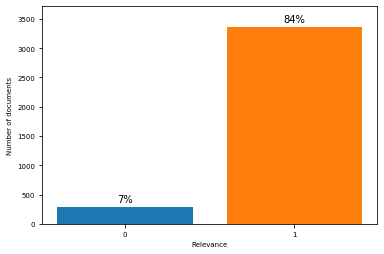

In [12]:
fig, ax = plt.subplots()
n = seen_df.shape[0]
y = df['relevant']
for i, (name, group) in enumerate(seen_df.groupby('relevant')):
    ax.bar(i, group.shape[0])
    ax.text(i, group.shape[0]+n*0.02, f'{group.shape[0]/n:.0%}',ha="center")

ax.set_xticks([0,1])
ax.set_ylim(ymax=ax.get_ylim()[1]*1.05)
ax.set_xlabel('Relevance')
ax.set_ylabel('Number of documents')

### Now we "vectorize" the data, representing each document as a weighted count of its words and phrases (bag of words and bigrams). Or if we already did this previously, then we reload the vectorized data

In [14]:
import pickle
revectorize = True
y = df['relevant']
if revectorize:
    vec = TfidfVectorizer(
        ngram_range=(1,2),
        min_df=4, max_df=0.8, strip_accents='unicode', 
        max_features=10000,
        use_idf=1,
        smooth_idf=1, sublinear_tf=1,
        stop_words="english",tokenizer=lu.tokenize
    )
    vec.fit(df.loc[seen_index,'content'])
    ab_X = vec.transform(df['content'])
    with open ('data/vec.pickle','wb') as f:
        pickle.dump(vec, f)
    import scipy.sparse
    scipy.sparse.save_npz('data/X.npz', ab_X)
else:
    with open ('data/vec.pickle','rb') as f:
        vec = pickle.load(f)
    ab_X = scipy.sparse.load_npz('data/X.npz')

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


### We build 3 types of classifiers, and test these with k-fold cross validation

In [15]:
from sklearn.model_selection import KFold
from importlib import reload  
import scoping.utils.learning_utils as lu
reload(scoping.utils.learning_utils)

models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',class_weight='balanced',probability=True)
    },
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
    },
    {
        'title': 'Naive Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    }
]

models = lu.cross_validate_models(ab_X, y, models, seen_index)

1
2
3
4
5
6
7
8
9
10


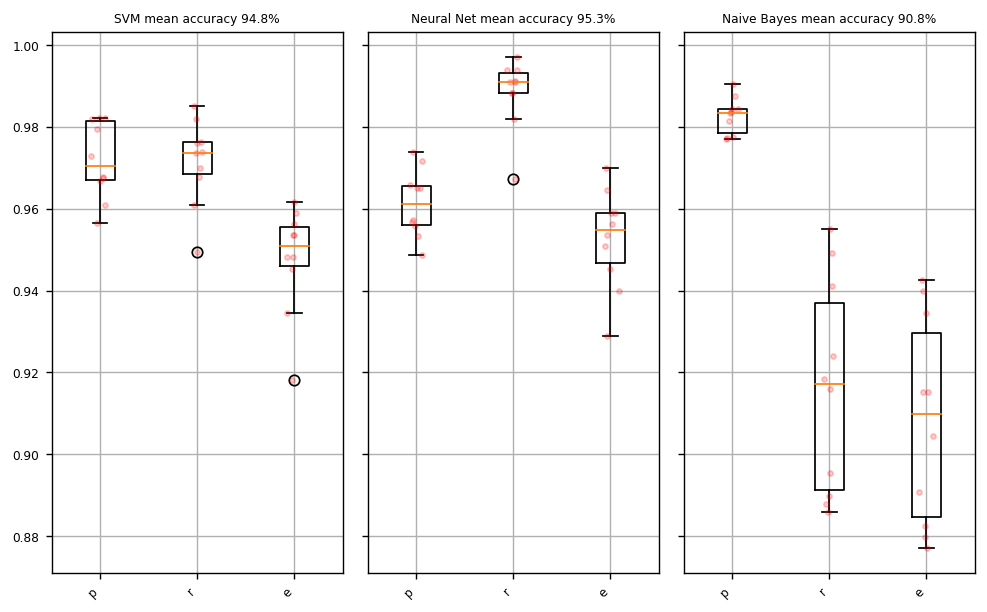

In [16]:
fig, axs = plt.subplots(1, len(models),dpi=125,figsize=(8,5),sharey=True)              
lu.plot_model_output(models,  ['p','r','e'], fig, axs)
plt.show()

In [17]:
model_df = pd.DataFrame(models)
model_df.to_csv(f"doctables/models_relevance_{now}.csv",index=False)

### We can choose the best performing model (for our purposes) and fit it on our unseen data, in order to predict the probability that our unseen documents are relevant

In [18]:
clf =  MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )

#clf = SVC(kernel='linear',class_weight='balanced',probability=True)

y = df['relevant']

clf.fit(ab_X[seen_index],y[seen_index])

y_pred = clf.predict_proba(ab_X[unseen_index])

327811 out of 378191 documents are predicted to be relevant


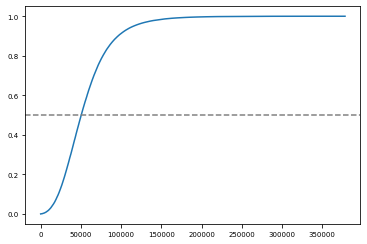

In [25]:
plt.close()

df['0 - relevance - prediction'] = None
df.loc[unseen_index,'0 - relevance - prediction'] = y_pred[:,1]

predicted_index = df[df['0 - relevance - prediction']>0.5].index

fig, ax = plt.subplots()

pdf = df.sort_values('0 - relevance - prediction').reset_index(drop=True)
ax.plot(pdf.index,pdf['0 - relevance - prediction'])
ax.axhline(0.5,linestyle="--",color="grey")

rel = df[pdf['0 - relevance - prediction']>0.5].shape[0]
tot = pdf[pdf['0 - relevance - prediction'].notna()].shape[0]


print(f"{rel} out of {tot} documents are predicted to be relevant")

df[['id','0 - relevance - prediction']].to_csv(f'doctables/predictions_{now}.csv',index=False)

plt.show()



### Now we make a new random sample

In [27]:
new_samples = False
if new_samples:
    now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
    t1, created = Tag.objects.get_or_create(
        title="predicted relevant sample {}".format(now),
        query=q
    )
    t1.save()

    tag = t1

    users = q.users.all()
    uc = len(users)
    max_docs = 500
    docs_added = 0
    for i, row in df.sort_values('prediction',ascending=False).head(3500).reset_index(drop=True).iterrows():
        d = Doc.objects.get(id=row['id'])
        if d.docownership_set.filter(query=q).exists():
            continue
        else:
            if docs_added < max_docs:
                d.tag.add(t1)
                docs_added+=1
            else:
                break  


    t1.update_tag()

    t1.update_tag()

## Now we try and predict governance and policies

Text(0.5, 0, 'Governance & policies')

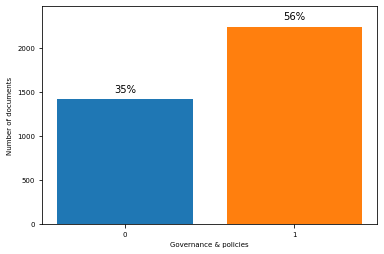

In [28]:
fig, ax = plt.subplots()
n = seen_df.shape[0]
for i, (name, group) in enumerate(df[df['seen']==1].groupby('2 - Governance & policies')):
    ax.bar(i, group.shape[0])
    ax.text(i, group.shape[0]+n*0.02, f'{group.shape[0]/n:.0%}',ha="center")
    
ax.set_ylim(ymax=ax.get_ylim()[1]*1.05)
ax.set_xticks([0,1])
ax.set_ylabel('Number of documents')
ax.set_xlabel('Governance & policies')

In [29]:
from sklearn.model_selection import KFold

y = df['2 - Governance & policies']
gov_models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',class_weight='balanced',probability=True)
    },
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
    },
    {
        'title': 'Naive Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    }
]

gov_models = lu.cross_validate_models(ab_X, y, gov_models, seen_index)

1
2
3
4
5
6
7
8
9
10


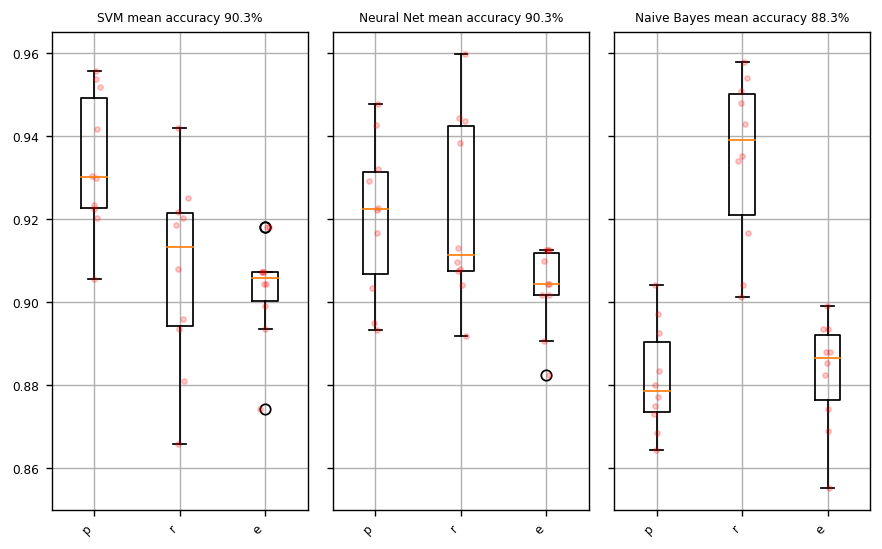

In [30]:

fig, axs = plt.subplots(1,3,dpi=125,figsize=double_figure,sharey=True)
lu.plot_model_output(gov_models,  ['p','r','e'], fig, axs)
plt.show()

# Here we predict which of the predicted relevant documents are also likely to be relevant to governance & policies

In [35]:
y = df['2 - Governance & policies']
clf =  MLPClassifier(
    solver='lbfgs', 
    alpha=0.1,
    hidden_layer_sizes=(10), 
    random_state=1
)
clf.fit(ab_X[seen_index],y[seen_index])
gov_predictions = clf.predict(ab_X[predicted_index])
gov_prob = clf.predict_proba(ab_X[predicted_index])

In [36]:
df.loc[predicted_index,"2 - Governance & policies - prediction"] = gov_prob[:,1]

In [37]:
model_df = pd.DataFrame(models)
model_df.to_csv(f"doctables/models_governance_policies_{now}.csv",index=False)

## Now we want to look at mitigation and adaptation

In [38]:
df['mit/ad'] = df['1 - Mitigation'] + df['1 - Adaptation']
print("seen documents:",df.loc[df['seen']==1,].shape[0])
print("seen mitigation documents:", df.loc[df['seen']==1,'1 - Mitigation'].sum())
print("seen adaptation documents", df.loc[df['seen']==1,'1 - Adaptation'].sum())
print("seen mitigation and adaptation documents", df.loc[df['mit/ad']==2,].shape[0])
print("seen non-mit/ad documents",df.loc[(df['seen']==1) & (df['mit/ad']==0),].shape[0])

seen documents: 3660
seen mitigation documents: 2310.0
seen adaptation documents 575.0
seen mitigation and adaptation documents 150
seen non-mit/ad documents 923


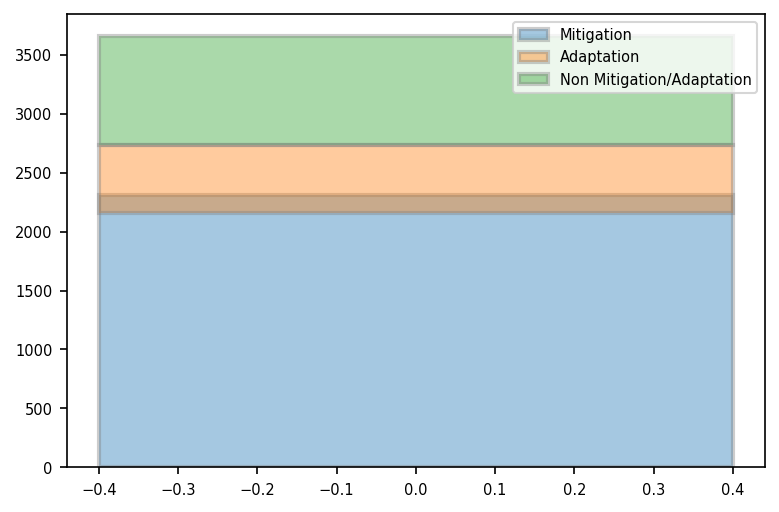

In [41]:
fig, ax = plt.subplots(dpi=150)

mitigation = df.loc[df['seen']==1,'1 - Mitigation'].sum()
adaptation = df.loc[df['seen']==1,'1 - Adaptation'].sum()
overlap = df.loc[df['mit/ad']==2,].shape[0]
nonmitad = df.loc[(df['seen']==1) & (df['mit/ad']==0),].shape[0]

lw = 2
alpha=0.4
ec = "grey"

ax.bar(
    0,mitigation,
    alpha=alpha, label="Mitigation",
    lw=lw, edgecolor=ec
)
ax.bar(
    0,adaptation,bottom=mitigation-overlap,
    alpha=alpha, label="Adaptation",
    lw=lw, edgecolor=ec
)
ax.bar(
    0,nonmitad,bottom=mitigation-overlap+adaptation,
    alpha=alpha, label="Non Mitigation/Adaptation",
    lw=lw, edgecolor=ec
)

ax.legend()

## We want to do multiclass prediction now

so we name the classes and create a matrix of class labels

In [39]:
classes = ["1 - Mitigation","1 - Adaptation"]
y = np.matrix(df[classes])
y.shape

(382223, 2)

and cross validate a model to see how well we can predict

In [40]:
from importlib import reload  
import scoping.utils.learning_utils as lu
reload(scoping.utils.learning_utils)

from sklearn.model_selection import KFold
multimodels = [
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },
]

multimodels, metrics, df = lu.cross_validate_models(ab_X, y, multimodels, seen_index, classes=classes, df=df)


1
2
3
4
5
6
7
8
9
10


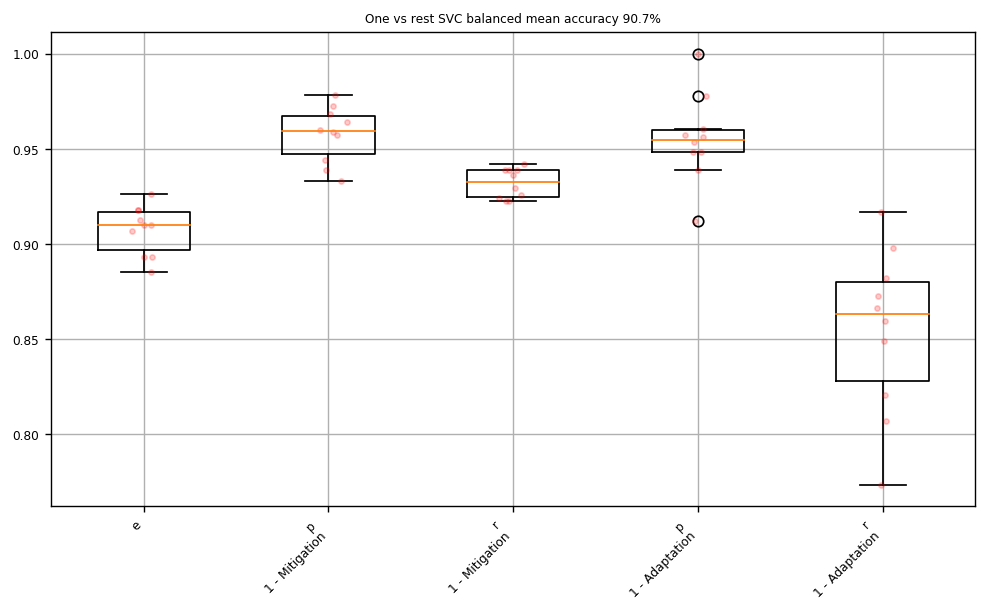

In [43]:
fig, axs = plt.subplots(1, len(multimodels),dpi=125,figsize=(8,5),sharey=True)              
lu.plot_model_output(multimodels, metrics, fig, [axs])
plt.show()

['1 - Mitigation - k_prediction_binary', '1 - Adaptation - k_prediction_binary']


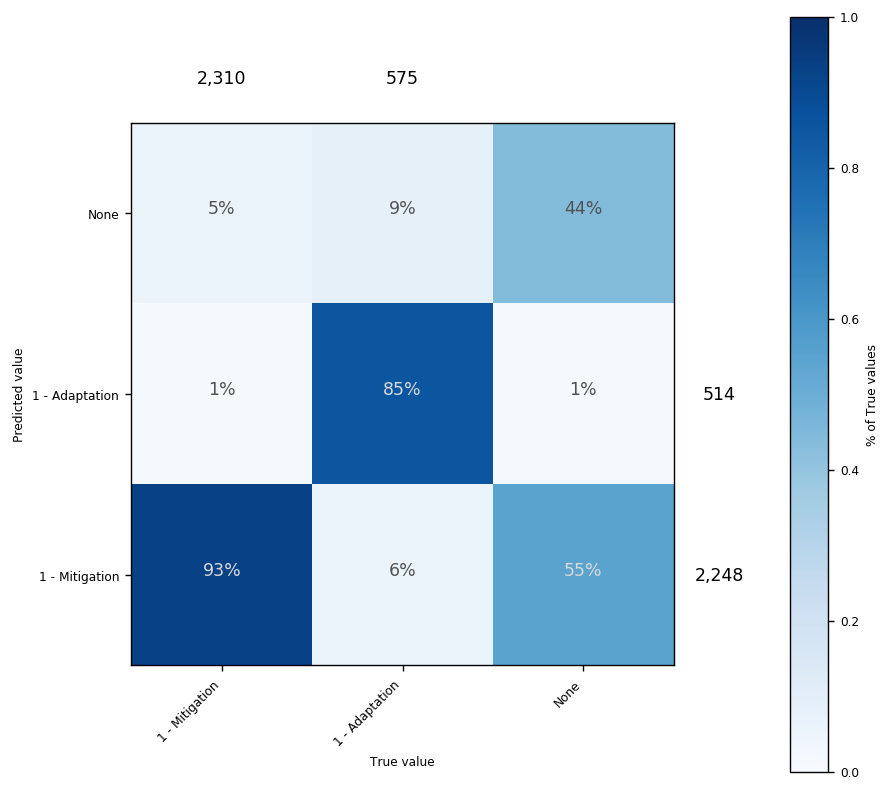

In [60]:
classes = ["1 - Mitigation","1 - Adaptation"]
cols = [f"{c} - k_prediction_binary" for c in classes]
print(cols)
y_pred = np.array(list(df.loc[seen_index,cols].values))
   
y_true = y[seen_index]

confusion_matrix = np.zeros(shape=(len(classes)+1,len(classes)+1),dtype=float)

norm = True

for j, c in enumerate(classes): #rows
    for k, c in enumerate(classes): #cols
        n = 0
        for i in range(len(seen_index)):
            if j==k:
                if y_true[i,j]+y_pred[i,k]==2:
                    n+=1
            else:
                if y_pred[i,j]+y_true[i,k]==2 and y_pred[i,k]+y_true[i,k]!=2:
                    n+=1/y_pred[i,].sum()
        confusion_matrix[j,k]=n
        
    sums_pred = y_pred.sum(axis=1).ravel()
    confusion_matrix[k+1,j]=y_true[np.argwhere(sums_pred==0).ravel(),j].sum()
    sums_true = y_true.sum(axis=1).ravel()
    confusion_matrix[j,k+1]=y_pred[np.argwhere(sums_true==0).ravel(),j].sum()
    confusion_matrix[j+1,k+1] = y_pred[np.argwhere(sums_true+sums_pred==0)].shape[0]


if norm is not False:
    confusion_matrix = confusion_matrix/confusion_matrix.sum(axis=0,keepdims=True)


fig, ax = plt.subplots(dpi=125, figsize=(8,8))


if norm is not False:
    mat = ax.imshow(confusion_matrix, cmap="Blues", vmin=0, vmax=1, origin="lower")
else:
    mat = ax.imshow(confusion_matrix, cmap="Blues",origin="lower")
    
classes = classes + ["None"]
for j, c in enumerate(classes):
    for k, c in enumerate(classes):
        n  = confusion_matrix[j,k]
        if n > np.max(confusion_matrix)/2:
            color="#d9d9d9"
        else:
            color="#525252"
        if norm is not False:
            ax.text(k,j, f"{confusion_matrix[j,k]:.0%}",ha="center",color=color)
        else:
            ax.text(k,j, f"{confusion_matrix[j,k]:.1f}",ha="center",color=color)

    if j < len(classes)-1:    
        ax.text(j,len(classes)-0.25,f"{y_true[:,j].sum():,.0f}",ha="center",va="center")
        ax.text(len(classes)-0.25, j, f"{y_pred[:,j].sum():,.0f}",ha="center",va="center")
        
ax.set_xticks(list(range(len(classes))))
ax.set_xticklabels([x.replace("12 - ","") for x in classes],rotation=45,ha="right")

ax.set_yticks(list(range(len(classes))))
ax.set_yticklabels([x.replace("12 - ","") for x in classes],ha="right")
ax.set_xlabel("True value")
ax.set_ylabel("Predicted value")

#ax.set_xlim(xmax=len(classes)+1)

cbar = fig.colorbar(mat, ax=ax, pad=0.15)
if norm is not False:
    cbar.set_label("% of True values")

In [61]:
model_df = pd.DataFrame(multimodels)
model_df.to_csv(f"doctables/multimodels_adaptation_mitigation_{now}.csv",index=False)

In [62]:
clf = OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
classes = ["1 - Mitigation","1 - Adaptation"]
y = np.matrix(df[classes])
y.shape

clf.fit(ab_X[seen_index],y[seen_index])
predictions = clf.predict(ab_X[predicted_index])

In [63]:
for i,c in enumerate(classes):
    df[f"{c} - prediction"] = np.NaN
    df.loc[predicted_index,f"{c} - prediction"] = predictions[:,i]

# Now we look at level 3 categories

[Text(0, 0, '3 - Economic instruments'),
 Text(0, 0, '3 - Goal setting'),
 Text(0, 0, '3 - Information policies'),
 Text(0, 0, '3 - International policies'),
 Text(0, 0, '3 - Planning and public provisioning/services'),
 Text(0, 0, '3 - Regulatory instruments'),
 Text(0, 0, '3 - Voluntary actions')]

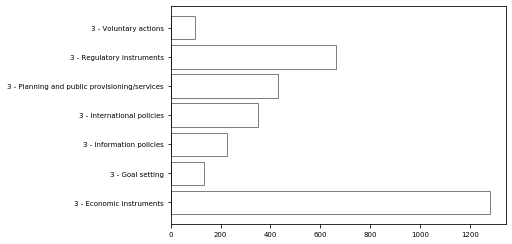

In [64]:
classes = [x for x in df.columns if "3 - " in x and "<hidden>" not in x and "prediction" not in x]
fig, ax = plt.subplots()
for i,c in enumerate(classes):
    ax.barh(i,df[c].sum(),color="None",edgecolor="black",linewidth=0.5)
ax.set_yticks(range(len(classes)))
ax.set_yticklabels(classes)

In [65]:
from importlib import reload  
import scoping.utils.learning_utils as lu
reload(scoping.utils.learning_utils)

print(classes)
y = np.matrix(df[classes])
from sklearn.model_selection import KFold
multimodels_3 = [
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },
]

multimodels_3, metrics, df = lu.cross_validate_models(ab_X, y, multimodels_3, seen_index, classes=classes, df = df, n_splits=6)


['3 - Economic instruments', '3 - Goal setting', '3 - Information policies', '3 - International policies', '3 - Planning and public provisioning/services', '3 - Regulatory instruments', '3 - Voluntary actions']
1
2
3
4
5
6


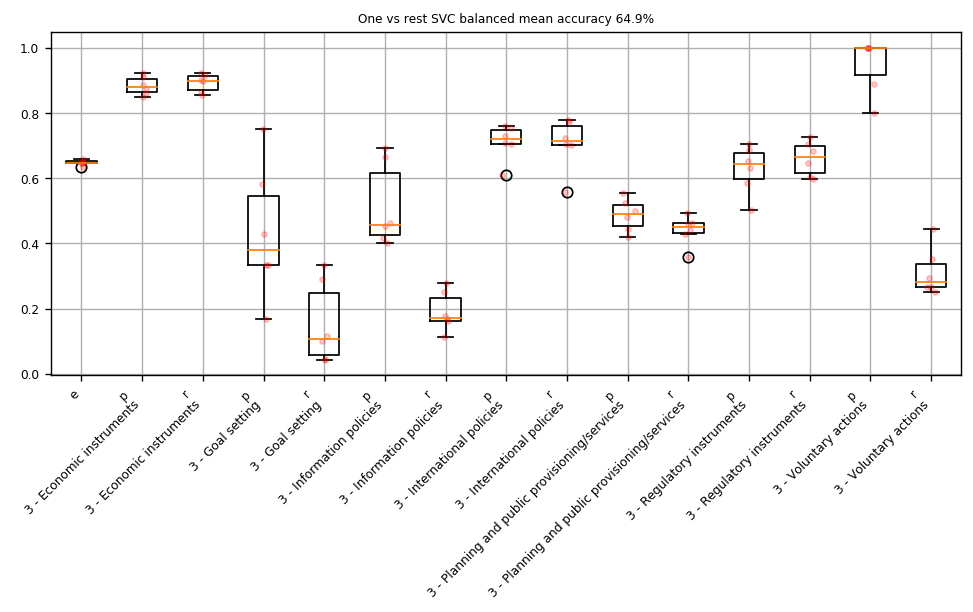

In [66]:
fig, axs = plt.subplots(1, len(multimodels_3),dpi=125,figsize=(8,5),sharey=True)              
lu.plot_model_output(multimodels_3, metrics, fig, [axs])
plt.show()

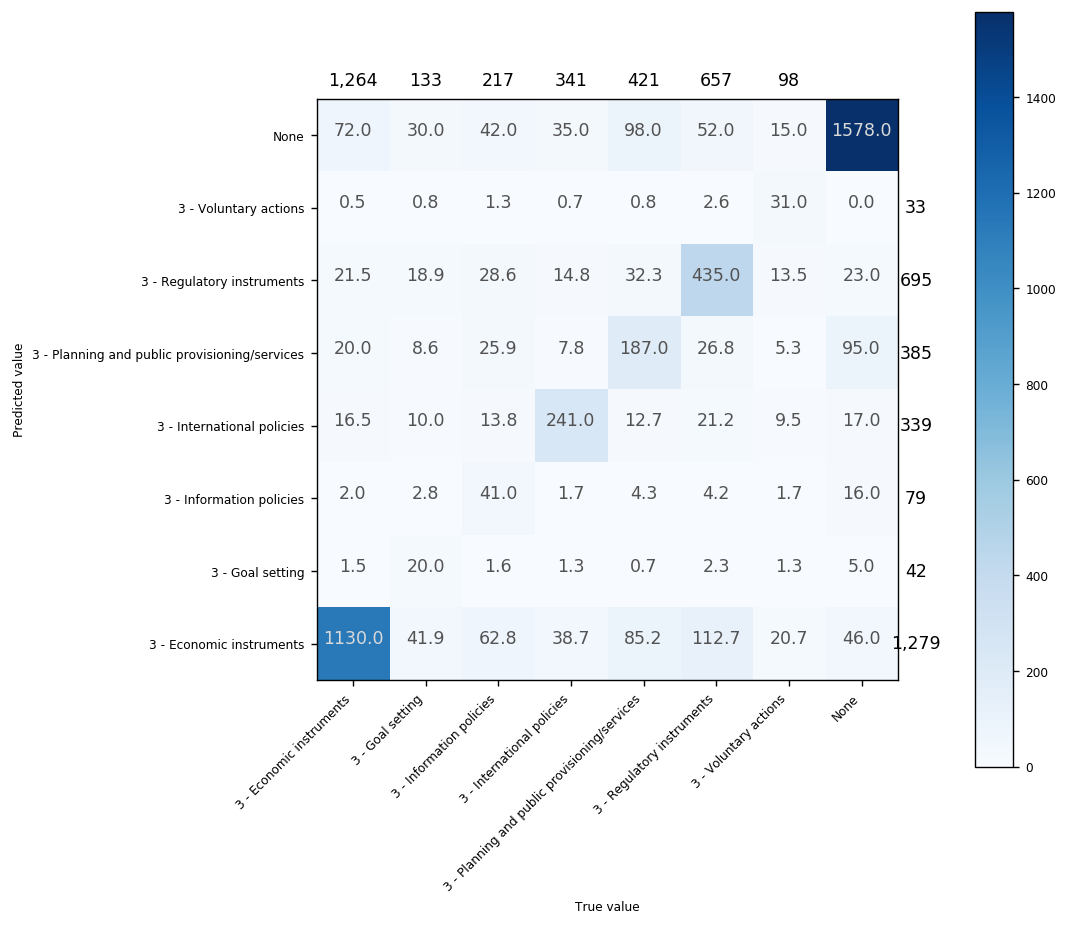

In [75]:
classes = [x for x in df.columns if "3 - " in x and "<hidden>" not in x and "prediction" not in x]
cols = [f"{c} - k_prediction_binary" for c in classes]
y_pred = np.array(list(df.loc[list(seen_index),cols].values))
   
y_true = y[seen_index]

confusion_matrix = np.zeros(shape=(len(classes)+1,len(classes)+1),dtype=float)

norm = False

for j, c in enumerate(classes): #rows
    for k, c in enumerate(classes): #cols
        n = 0
        for i in range(len(seen_index)):
            if j==k:
                if y_true[i,j]+y_pred[i,k]==2:
                    n+=1
            else:
                if y_pred[i,j]+y_true[i,k]==2 and y_pred[i,k]+y_true[i,k]!=2:
                    n+=1/y_pred[i,].sum()
        confusion_matrix[j,k]=n
        
    sums_pred = y_pred.sum(axis=1).ravel()
    confusion_matrix[k+1,j]=y_true[np.argwhere(sums_pred==0).ravel(),j].sum()
    sums_true = y_true.sum(axis=1).ravel()
    confusion_matrix[j,k+1]=y_pred[np.argwhere(sums_true==0).ravel(),j].sum()
    confusion_matrix[j+1,k+1] = y_pred[np.argwhere(sums_true+sums_pred==0)].shape[0]
        
#confusion_matrix[0,3] = 699


if norm is not False:
    confusion_matrix = confusion_matrix/confusion_matrix.sum(axis=0,keepdims=True)


fig, ax = plt.subplots(dpi=125, figsize=(8,8))


if norm is not False:
    mat = ax.imshow(confusion_matrix, cmap="Blues", vmin=0, vmax=1, origin="lower")
else:
    mat = ax.imshow(confusion_matrix, cmap="Blues",origin="lower")
    
classes = classes + ["None"]
for j, c in enumerate(classes):
    for k, c in enumerate(classes):
        n  = confusion_matrix[j,k]
        if n > np.max(confusion_matrix)/2:
            color="#d9d9d9"
        else:
            color="#525252"
        if norm is not False:
            ax.text(k,j, f"{confusion_matrix[j,k]:.0%}",ha="center",color=color)
        else:
            ax.text(k,j, f"{confusion_matrix[j,k]:.1f}",ha="center",color=color)
            
    #ax.text(j,len(classes),f"{confusion_matrix[k+1,j]:,.0f}",ha="center",va="center")
    #ax.text(len(classes),j,f"{confusion_matrix[j,k+1]:,.0f}",ha="center",va="center")
    #ax.text(len(classes),j,f"{confusion_matrix[j,k+1]:,.0f}",ha="center",va="center")
    
    if j < len(classes)-1:    
        ax.text(j,len(classes)-0.25,f"{y_true[:,j].sum():,.0f}",ha="center",va="center")
        ax.text(len(classes)-0.25, j, f"{y_pred[:,j].sum():,.0f}",ha="center",va="center")
        
ax.set_xticks(list(range(len(classes))))
ax.set_xticklabels([x.replace("12 - ","") for x in classes],rotation=45,ha="right")

ax.set_yticks(list(range(len(classes))))
ax.set_yticklabels([x.replace("12 - ","") for x in classes],ha="right")
ax.set_xlabel("True value")
ax.set_ylabel("Predicted value")


cbar = fig.colorbar(mat, ax=ax, pad=0.1)
if norm is not False:
    cbar.set_label("% of True values")

In [72]:
classes = [x for x in df.columns if "3 - " in x and "<hidden>" not in x and "prediction" not in x]
y = np.matrix(df[classes])
y.shape
clf.fit(ab_X[seen_index],y[seen_index])
predictions = clf.predict(ab_X[unseen_index])

In [73]:
for i,c in enumerate(classes):
    df.loc[unseen_index,f"{c} - prediction"] = predictions[:,i]

In [76]:
keep_columns = []
for c in df.columns:
    if "k_prediction" in c:
        continue
    keep_columns.append(c)
    
keep_columns

['PY',
 'content',
 'id',
 'relevant',
 'seen',
 'title',
 'wosarticle__de',
 'wosarticle__wc',
 '1 - Adaptation',
 '1 - Mitigation',
 '2 - Governance & policies',
 '3 - <hidden>tax/emission trading',
 '3 - Economic instruments',
 '3 - Goal setting',
 '3 - Government procurement & public services<hidden>',
 '3 - Information policies',
 '3 - Information<hidden>',
 '3 - International policies',
 '3 - Other<hidden>',
 '3 - Planning and public provisioning/services',
 '3 - Regulation<hidden>',
 '3 - Regulatory instruments',
 '3 - Subsidies<hidden>',
 '3 - Voluntary actions',
 '3 - voluntary agreement<hidden>',
 '4 - Behavioral interventions',
 '4 - Emissions trading ',
 '4 - Feed in tariffs',
 '4 - Financial mechanisms',
 '4 - Financial regulation & insurance',
 '4 - Government procurement',
 '4 - Infrastructure policy & management',
 '4 - Innovation policies',
 '4 - International agreements',
 '4 - Investments, credits and loans',
 '4 - Labeling and certificates /Consumption and productio

In [77]:
df[keep_columns].to_csv('data/document_ratings.csv',index=False)

In [ ]:
plt.close()

df['prediction'] = None
df.loc[unseen_index,'prediction'] = both_predictions

fig, ax = plt.subplots()

pdf = df.sort_values('prediction').reset_index(drop=True)
ax.plot(pdf.index,pdf['prediction'])
ax.axhline(0.5,linestyle="--",color="grey")

rel = df[pdf['prediction']>0.5].shape[0]
tot = pdf[pdf['prediction'].notna()].shape[0]


print(f"{rel} out of {tot} documents are predicted to be relevant")

df[['id','prediction']].to_csv(f'doctables/predictions_adaptation_mitigation_{now}.csv',index=False)

plt.show()

In [ ]:
tag, created = Tag.objects.get_or_create(
    title="predicted mitigation&adaptation sample {}".format(now),
    query=q
)
tag.save()

max_docs = 100
docs_added = 0
for i, row in df.sort_values('prediction',ascending=False).head(3500).reset_index(drop=True).iterrows():
    d = Doc.objects.get(id=row['id'])
    if d.docownership_set.filter(query=q).exists():
        continue
    else:
        if docs_added < max_docs:
            d.tag.add(tag)
            docs_added+=1
        else:
            break  

    
tag.update_tag()

### True positives and negatives for mitigation and adaptation

In [ ]:
kf = KFold(n_splits=10)
i=0
all_mistakes = None
df['mispredicted'] = 0
df['fn_mit'] = 0
df['fp_mit'] = 0
df['fn_ad'] = 0
df['fp_ad'] = 0


all_fps = None
all_fns = None

classes = ["Mitigation","Adaptation"]
y = np.matrix(df[classes])
y.shape

for k_train, k_test in kf.split(seen_index):
    k_train = seen_index[k_train]
    k_test = seen_index[k_test]
    
    clf = OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    clf.fit(ab_X[k_train],y[k_train])
    
    y_pred = clf.predict_proba(ab_X[k_test])
    
    
    fnm = np.argwhere((np.array(y[k_test,0])[:,0]>0.5) & (y_pred[:,0] < 0.5))[:,0]
    df.loc[k_test[fnm],'fn_mit'] = 1
    fpm = np.argwhere((np.array(y[k_test,0])[:,0]<0.5) & (y_pred[:,0] > 0.5))[:,0]
    df.loc[k_test[fpm],'fp_mit'] = 1
    
    fna = np.argwhere((np.array(y[k_test,1])[:,0]>0.5) & (y_pred[:,1] < 0.5))[:,0]
    df.loc[k_test[fna],'fn_ad'] = 1
    fpa = np.argwhere((np.array(y[k_test,1])[:,0]<0.5) & (y_pred[:,1] > 0.5))[:,0]
    df.loc[k_test[fpa],'fp_ad'] = 1
    
    
    mistakes = np.append(np.append(np.append(fpm,fnm),fna),fpa)
    
    df.loc[k_test[mistakes],'mispredicted'] = 1
    


In [ ]:
df[df['mispredicted']==1].shape

In [ ]:
tag, created = Tag.objects.get_or_create(
    title="mitigation &/or adaptation false positives and negatives {}".format(now),
    query=q
)
tag.save()
for i, row in df.query('mispredicted==1').iterrows():
    d = Doc.objects.get(pk=row['id'])
    d.tag.add(tag)
tag.update_tag()

In [ ]:
df.query('fn_mit==1|fp_mit==1').shape

In [ ]:
tag, created = Tag.objects.get_or_create(
    title="mitigation only false positives and negatives {}".format(now),
    query=q
)
tag.save()
for i, row in df.query('fn_mit==1|fp_mit==1').iterrows():
    d = Doc.objects.get(pk=row['id'])
    d.tag.add(tag)
tag.update_tag()

In [ ]:
tag, created = Tag.objects.get_or_create(
    title="adaptation only false positives and negatives {}".format(now),
    query=q
)
tag.save()
for i, row in df.query('fn_ad==1|fp_ad==1').iterrows():
    d = Doc.objects.get(pk=row['id'])
    d.tag.add(tag)
tag.update_tag()

A discussion of the different metrics is provided here
https://scikit-learn.org/stable/modules/model_evaluation.html#multilabel-ranking-metrics

## Now we want to look at adaptation+policy

In [ ]:
classes = ["Mitigation","Governance & policies"]
y = np.matrix(df[classes])
y.shape

In [ ]:
from sklearn.model_selection import KFold
multimodels_adgov = [
    {
        'title': 'One vs rest SVC', 
        'model': OneVsRestClassifier(SVC(kernel='linear', probability=True))
    },
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },
]

multimodels_adgov, metrics_adgov = lu.cross_validate_models(ab_X, y, multimodels_adgov, seen_index, classes=classes)


In [ ]:
fig, axs = plt.subplots(1, len(multimodels),dpi=125,figsize=(8,5),sharey=True)              
lu.plot_model_output(multimodels_adgov, metrics_adgov, fig, axs)
plt.show()

In [ ]:
clf = OneVsRestClassifier(SVC(kernel='linear', probability=True))

clf.fit(ab_X[seen_index],y[seen_index])
predictions = clf.predict_proba(ab_X[unseen_index])
both_predictions = predictions.min(axis=1)

In [ ]:
both_predictions

In [ ]:
plt.close()

df['prediction'] = None
df.loc[unseen_index,'prediction'] = both_predictions

fig, ax = plt.subplots()

pdf = df.sort_values('prediction').reset_index(drop=True)
ax.plot(pdf.index,pdf['prediction'])
ax.axhline(0.5,linestyle="--",color="grey")

rel = df[pdf['prediction']>0.5].shape[0]
tot = pdf[pdf['prediction'].notna()].shape[0]


print(f"{rel} out of {tot} documents are predicted to be relevant")

df[['id','prediction']].to_csv(f'doctables/predictions_adaptation_policy_{now}.csv',index=False)

plt.show()

In [ ]:
now=datetime.datetime.now()
tag, created = Tag.objects.get_or_create(
    title="predicted adaptation&policy sample {}".format(now),
    query=q
)
tag.save()

max_docs = 500
docs_added = 0
for i, row in df.sort_values('prediction',ascending=False).head(3500).reset_index(drop=True).iterrows():
    d = Doc.objects.get(id=row['id'])
    if d.docownership_set.filter(query=q).exists():
        continue
    else:
        if docs_added < max_docs:
            d.tag.add(tag)
            docs_added+=1
        else:
            break  

    
tag.update_tag()

In [ ]:
madf = df[(df['Mitigation']==1) & (df['Adaptation']==1)]
madf.shape

tag, created = Tag.objects.get_or_create(
    title="labelled adaptation&mitigation sample {}".format(now),
    query=q
)
tag.save()

jan = User.objects.get(username="minj")

for i, row in madf.sample(100).iterrows():
    d = Doc.objects.get(id=row['id'])
    d.tag.add(tag)
    do, created = DocOwnership.objects.get_or_create(
        user = jan,
        doc = d,
        tag = tag
    )
    
tag.update_tag()

In [ ]:
django.db.connection.close()
cat_dict = {}
for c in Category.objects.filter(project=p):
    if c.child_category.exists():
        cat_dict[c.name.replace('<hidden>','').strip()] = list(
            c.child_category.values_list('name',flat = True)
        )
    
cat_dict

In [ ]:
fig = plt.figure(figsize=(16,24),dpi=150)
for i, (n, v) in enumerate(cat_dict.items()):
    v = df.columns.intersection(v)
    ax = fig.add_subplot(5,3,i+1)
    pdf = df.loc[df['relevant']==1,v] 
    pdf['any'] = pdf.sum(axis=1)
    ndocs = pdf['any'].astype("bool").sum()
    pdf = pdf[v].melt()
    
    pdf.groupby('variable').sum().plot.bar(ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha="right")
    ax.set_title(f"{n} - {ndocs} docs")
    
fig.tight_layout()

In [ ]:
classes = cat_dict['Governance & policies']
y = np.matrix(df[classes])
print(y.shape)

In [ ]:
from sklearn.model_selection import KFold
multimodels_gov = [
    {
        'title': 'One vs rest SVC', 
        'model': OneVsRestClassifier(SVC(kernel='linear', probability=True))
    },
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },
]

multimodels_gov, metrics_gov = lu.cross_validate_models(ab_X, y, multimodels_gov, seen_index, classes=classes)

In [ ]:
fig, axs = plt.subplots(1, len(multimodels_gov),dpi=125,figsize=(8,5),sharey=True)              
lu.plot_model_output(multimodels_gov, metrics_gov, fig, axs)
plt.show()

In [ ]:
fig, axs = plt.subplots(1, len(multimodels_gov),dpi=125,figsize=(8,5),sharey=True)              
lu.plot_model_output(multimodels_gov, m_metrics, fig, axs)
plt.show()

In [ ]:
model_df = pd.DataFrame(multimodels_gov)
model_df.to_csv(f"doctables/multimodels_gov_{now}.csv",index=False)